In [1]:
import os
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Taking a look at the dataset
labels = pd.read_csv('Dataset/stage_2_train_labels.csv')
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [3]:
# Dropping duplicates, because we're building a classifier, and not a detection model.
labels = labels.drop_duplicates('patientId')

In [4]:
ROOT_PATH = Path('Dataset/stage_2_train_images/')
SAVE_PATH = Path('./Processed')
SAVE_PATH.mkdir(parents=True, exist_ok=True)

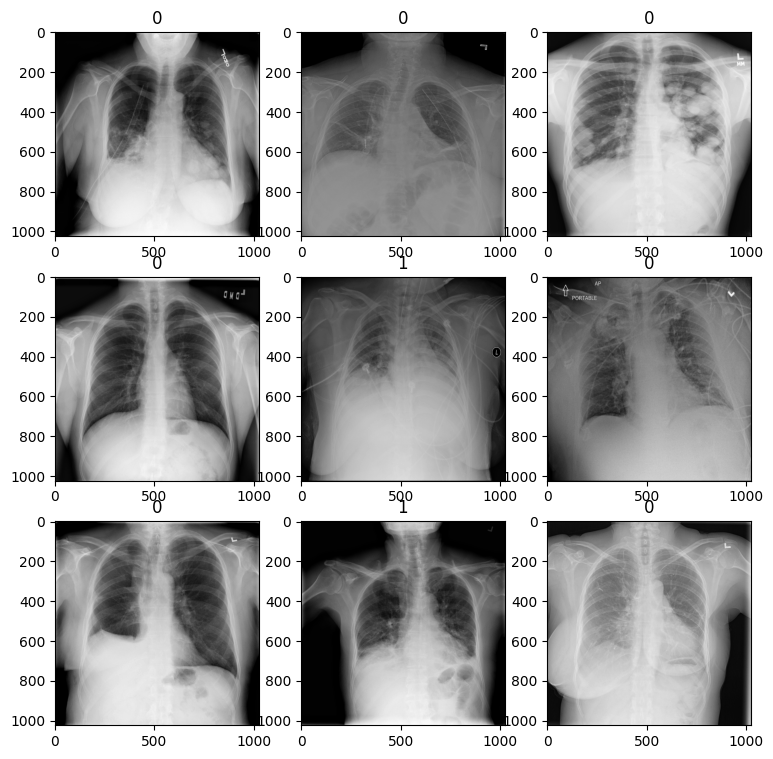

In [5]:
# Plotting a few images to get familiar with the data
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels['patientId'].iloc[c]
        dcm_path = ROOT_PATH / patient_id
        dcm_path = dcm_path.with_suffix('.dcm')
        dcm = pydicom.read_file(dcm_path).pixel_array

        label = labels['Target'].iloc[c]

        axis[i][j].imshow(dcm, cmap='gray')
        axis[i][j].set_title(label)
        c += 1

In [6]:
sums, sums_squared = 0, 0
# 
for c, patient_id in enumerate(tqdm(labels['patientId'])):
    patient_id = labels['patientId'].iloc[c]
    dcm_path = ROOT_PATH / patient_id
    dcm_path = dcm_path.with_suffix('.dcm')
# Normalizing data
    dcm = pydicom.read_file(dcm_path).pixel_array /255
# Resizes the image to 224x224 to match the input size expected by ResNet18
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    label = labels.Target.iloc[c]
# Separating train and validation sets
    train_or_val = 'train' if c < 24000 else 'val'

    current_save_path = SAVE_PATH / train_or_val / str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path / patient_id, dcm_array)

    normalizer = 224 * 224
    if train_or_val == 'train':
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer


  0%|          | 0/26684 [00:00<?, ?it/s]

In [7]:
# Calculating mean and std for normalization in Model-Training
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean**2)

In [8]:
mean, std

(0.4903962485384803, 0.24795070634161256)

In [10]:
dcm_array

array([[0.552  , 0.5933 , 0.5464 , ..., 0.5913 , 0.6094 , 0.612  ],
       [0.3257 , 0.3074 , 0.252  , ..., 0.5884 , 0.601  , 0.618  ],
       [0.0988 , 0.08527, 0.0762 , ..., 0.5884 , 0.6    , 0.612  ],
       ...,
       [0.02325, 0.02493, 0.02663, ..., 0.8545 , 0.847  , 0.836  ],
       [0.02101, 0.0176 , 0.02762, ..., 0.86   , 0.8516 , 0.847  ],
       [0.01877, 0.03223, 0.03009, ..., 0.8433 , 0.837  , 0.836  ]],
      dtype=float16)